In [1]:
#Include Libraries:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import seaborn as sns
from scipy import stats

In [2]:
#Read CSV Files
dataset_dir = "./Dataset/"
chotot_dataset = pd.read_csv(dataset_dir + "chotot.csv",index_col = [0])
phongtro123_dataset = pd.read_csv(dataset_dir + "phongtro123.csv",index_col=[0])
print(phongtro123_dataset.head())
print(chotot_dataset.head())

       Price  Area            Ward     District
0  1300000.0    20        Hòa Minh   Liên Chiểu
1  3000000.0    25   Nại Hiên Đông      Sơn Trà
2  1500000.0    15         Hòa Khê    Thanh Khê
3  2600000.0    30      An Hải Bắc      Sơn Trà
4  3200000.0    40   Hòa Khánh Nam   Liên Chiểu
     Price  Area  Deposit Fee        Furniture           Ward     District
0  1600000    20     500000.0              NaN   Hòa Thọ Đông       Cẩm Lệ
1  1100000    40      50000.0  Nội thất đầy đủ    Thuận Phước     Hải Châu
2  1500000    20     500000.0        Nhà trống       Hòa Phát       Cẩm Lệ
3  2500000    25    2500000.0  Nội thất đầy đủ       Hòa Minh   Liên Chiểu
4  1200000    30    1000000.0  Nội thất đầy đủ    Thuận Phước     Hải Châu


In [3]:
#Preparing Dataset for Feature Engineering
chotot_dataset = chotot_dataset.drop(columns=['Deposit Fee'])
Dataset = pd.concat([chotot_dataset, phongtro123_dataset],ignore_index=True)
print(Dataset.shape)
Dataset.head()

(1654, 5)


,Price,Area,Furniture,Ward,District
0,1600000.0,20,NaN,Hòa Thọ Đông,Cẩm Lệ
1,1100000.0,40,Nội thất đầy đủ,Thuận Phước,Hải Châu
2,1500000.0,20,Nhà trống,Hòa Phát,Cẩm Lệ
3,2500000.0,25,Nội thất đầy đủ,Hòa Minh,Liên Chiểu
4,1200000.0,30,Nội thất đầy đủ,Thuận Phước,Hải Châu


In [4]:
#Checking Nan values in Dataset
Dataset.isna().sum()

Price          20
Area            0
Furniture    1213
Ward          103
District       36
dtype: int64

In [5]:
#Splitting Continous and Categorical columns
Categorical_cols = ['Ward','District']
Continous_cols = ['Area']

In [6]:
#Filling Nan values in these feature columns
Dataset = Dataset[Dataset['Price'].notna()]
Dataset.Furniture.fillna(value = "Nhà trống", inplace = True)
Dataset.Ward.fillna(value = " Unknown W", inplace = True)
Dataset.District.fillna(value = " Unknown D", inplace = True)
Dataset.District[Dataset.District == ' Hoà Vang'] = ' Hòa Vang'
Dataset.isna().sum()

/var/folders/2r/vgdn5c2j5fb567xb2nm5_qfm0000gn/T/ipykernel_3934/1940412937.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataset.District[Dataset.District == ' Hoà Vang'] = ' Hòa Vang'


Price        0
Area         0
Furniture    0
Ward         0
District     0
dtype: int64

In [7]:
#Removing Outlier in Feature Area
Q1 = Dataset.quantile(0.2)
Q3 = Dataset.quantile(0.8)
IQR = Q3 - Q1

Dataset = Dataset[~((Dataset < (Q1 - 1.5 * IQR)) |(Dataset > (Q3 + 1.5 * IQR))).any(axis=1)]

/var/folders/2r/vgdn5c2j5fb567xb2nm5_qfm0000gn/T/ipykernel_3934/3706641465.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  Dataset = Dataset[~((Dataset < (Q1 - 1.5 * IQR)) |(Dataset > (Q3 + 1.5 * IQR))).any(axis=1)]
/var/folders/2r/vgdn5c2j5fb567xb2nm5_qfm0000gn/T/ipykernel_3934/3706641465.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  Dataset = Dataset[~((Dataset < (Q1 - 1.5 * IQR)) |(Dataset > (Q3 + 1.5 * IQR))).any(axis=1)]


# Data Visualization

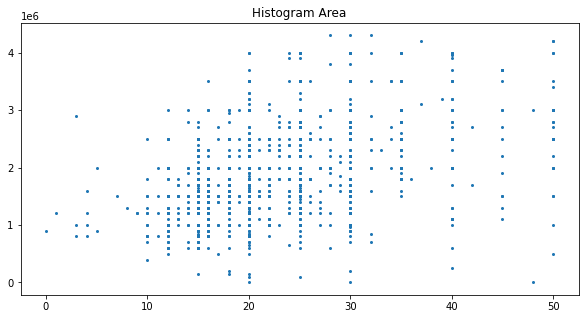

In [8]:
#Visualizing Area Feature
plt.figure(figsize = (10,5))
plt.scatter(x = Dataset['Area'], y = Dataset['Price'],s = 4)
plt.title("Histogram Area")
plt.show()

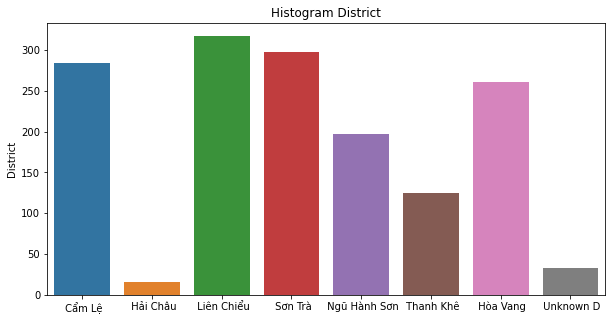

In [9]:
plt.figure(figsize = (10,5))
sns.barplot(x = Dataset['District'].unique(),y = Dataset.groupby('District')['District'].count())
plt.title("Histogram District")
plt.show()

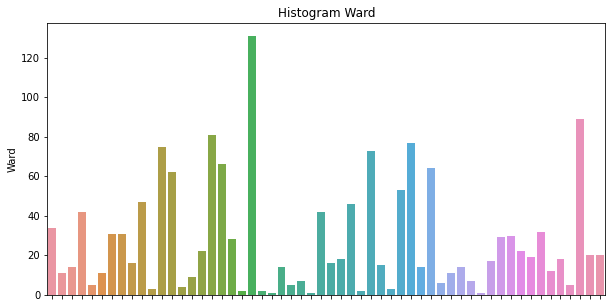

In [10]:
fig = plt.figure(figsize = (10,5))
g = sns.barplot(x = Dataset['Ward'].unique(),y = Dataset.groupby('Ward')['Ward'].count())
g.set(xticklabels=[])
plt.title("Histogram Ward")
plt.show()

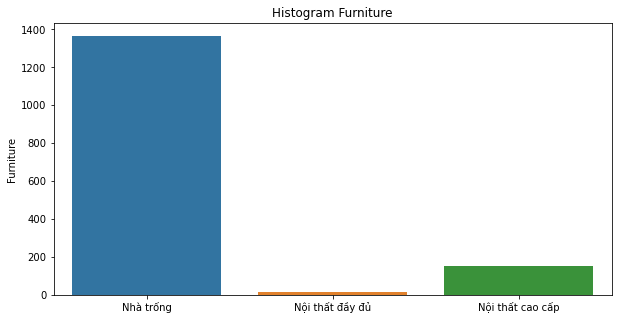

In [11]:
fig = plt.figure(figsize = (10,5))
sns.barplot(x = Dataset['Furniture'].unique(),y = Dataset.groupby('Furniture')['Furniture'].count())
plt.title("Histogram Furniture")
plt.show()

# Data Encryption

In [12]:
#Using Onehot Encoding in Categorical Columns
ohe = OneHotEncoder(sparse=False)
ohe_set = ohe.fit_transform(Dataset[Categorical_cols])
ohe_name_col = []
for i in ohe.categories_:
    ohe_name_col+=(i.tolist())

In [13]:
#Using Label Encoding in Furniture Columns
le = LabelEncoder()
le_set = ohe.fit_transform(Dataset[['Furniture']])

In [14]:
#Using Standard Scaler in Continous Columns
std = StandardScaler()
std_set = std.fit_transform(Dataset[Continous_cols])

In [15]:
#Concating all dataframe which we created recently:
Train_set = pd.concat([pd.DataFrame(data=ohe_set,columns = ohe_name_col), pd.DataFrame(data = le_set)], axis = 1)
Train_set = pd.concat([Train_set,pd.DataFrame(data = std_set, columns = Continous_cols)], axis = 1)
Train_set.head()

,An Hải Bắc,An Hải Tây,An Hải Đông,An Khê,Bình Hiên,Bình Thuận,Chính Gián,Hoà Hải,Hoà Quý,Hòa An,...,Hải Châu,Liên Chiểu,Ngũ Hành Sơn,Sơn Trà,Thanh Khê,Unknown D,0,1,2,Area
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.360549
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.158928
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.360549
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269321
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.899190


In [16]:
#Using Standard Scaler in Target column (Price)
Target_std = StandardScaler().fit(Dataset[['Price']])
Target_set = pd.DataFrame(data = Target_std.transform(Dataset[['Price']]), columns = ['Price'])
Target_set.head()

,Price
0,-0.407256
1,-1.070474
2,-0.539900
3,0.786535
4,-0.937830


# Predict

In [17]:
#Include Libraries:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [18]:
#Splitting dataset that 80 percent is used to train the model and 20 percent is used to evaluate it
print(Train_set.shape, Target_set.shape)
x_train, x_test, y_train, y_test = train_test_split(Train_set, Target_set, random_state=53, shuffle=True,test_size = 0.2)

(1530, 68) (1530, 1)


In [19]:
def Get_Score(algo, name):
    algo.fit(x_train,y_train)
    y_pred = algo.predict(x_test)
    x_ax = range(len(y_pred))
    original_set = Target_std.inverse_transform(y_test)
    predicted_set = Target_std.inverse_transform(y_pred)
    plt.scatter(x_ax, original_set, s= 4, color="blue", label="original")
    plt.plot(x_ax, predicted_set, color="red", label="predicted")
    plt.legend()
    plt.show()
    score = mean_squared_error(y_test,y_pred,squared = False)
    print(name,'Mean squared error: ',score)
    return predicted_set, original_set

### Light Gradient Boosting

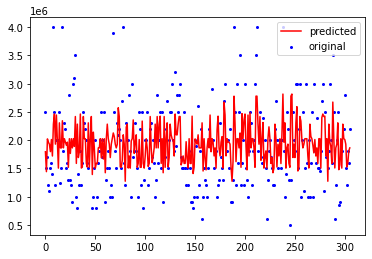

LightGradientBoosting Mean squared error:  0.8117497554362348


In [20]:
lightgb = lgb.LGBMRegressor(n_estimators=500,
                max_depth=7,
                min_split_gain=4,
                min_child_samples=6)
predicted_set, original_set = Get_Score(lightgb,'LightGradientBoosting')

### Random Forest

/var/folders/2r/vgdn5c2j5fb567xb2nm5_qfm0000gn/T/ipykernel_3934/1063694331.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  algo.fit(x_train,y_train)


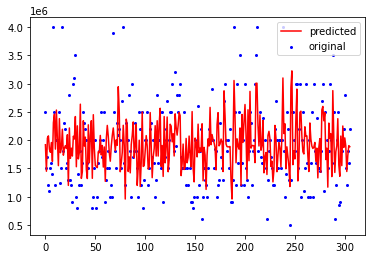

RandomForest Mean squared error:  0.7977373061301462


In [21]:
RF = RandomForestRegressor(n_estimators=500,
                            max_depth=7,
                            max_features='auto',
                            verbose=0,
                            random_state=30,
                            min_samples_leaf=6,
                            oob_score=True,
                            min_samples_split=4)
predicted_set, original_set = Get_Score(RF, 'RandomForest')

### KNN

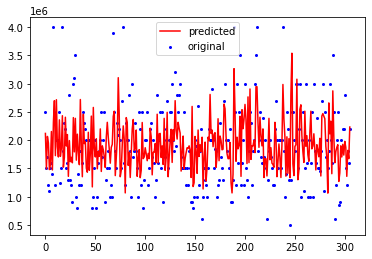

KNN Mean squared error:  0.8088406989710293


In [22]:
knn = KNeighborsRegressor(n_neighbors=15)
predicted_set, original_set = Get_Score(knn, 'KNN')

### 

### Gradient Boosting Regressor

/Users/phanvanhung/miniforge3/envs/tfvenv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


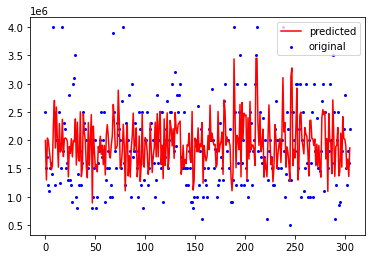

GradientBoosting Mean squared error:  0.7890980576746937


In [23]:
GBC = GradientBoostingRegressor(n_estimators=100,
                                max_features='auto')
predicted_set, original_set = Get_Score(GBC,'GradientBoosting')

# Result

In [25]:
predicted_set = pd.DataFrame(data = np.ravel(predicted_set))
original_set = pd.DataFrame(data = np.ravel(original_set))
Result_set = pd.concat([predicted_set,original_set], axis = 1)
Result_set.to_csv('Result.csv')